<a href="https://colab.research.google.com/github/mackoel/soy_modeling/blob/master/soya_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Soy blossom period prediction model

## Setup

### Configure environment

In [3]:
!pip install pydot

### Show the machine details the environment is running on

Show CPU info

In [4]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
model name	: Intel(R) Xeon(R) CPU @ 2.30GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2300.000
cache size	: 46080 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid pni pclmulqdq ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm pti ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 avx2 smep bmi2 erms xsaveopt arat arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf
bogomips	: 4600.00
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 bits virtual
power management:

processor	: 1
vendor_id	: GenuineIntel
cpu family	: 6
model		: 63
mode

Show RAM info

In [5]:
!cat /proc/meminfo

MemTotal:       13335212 kB
MemFree:        11124124 kB
MemAvailable:   12632440 kB
Buffers:           63860 kB
Cached:          1608512 kB
SwapCached:            0 kB
Active:           518372 kB
Inactive:        1448044 kB
Active(anon):     271608 kB
Inactive(anon):      340 kB
Active(file):     246764 kB
Inactive(file):  1447704 kB
Unevictable:           0 kB
Mlocked:               0 kB
SwapTotal:             0 kB
SwapFree:              0 kB
Dirty:               628 kB
Writeback:             0 kB
AnonPages:        294160 kB
Mapped:           155892 kB
Shmem:               868 kB
Slab:             141544 kB
SReclaimable:     111016 kB
SUnreclaim:        30528 kB
KernelStack:        3796 kB
PageTables:         4788 kB
NFS_Unstable:          0 kB
Bounce:                0 kB
WritebackTmp:          0 kB
CommitLimit:     6667604 kB
Committed_AS:    1806416 kB
VmallocTotal:   34359738367 kB
VmallocUsed:           0 kB
VmallocChunk:          0 kB
AnonHugePages:         0 kB
ShmemHugePages:  

Show GPU info

In [6]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4172840873117237056, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13477617590842650785
 physical_device_desc: "device: XLA_CPU device", name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 9122805177183770068
 physical_device_desc: "device: XLA_GPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 11281553818
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14306915272300075695
 physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7"]

### Import modules

In [0]:
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score as r2_metric

In [8]:
from keras import backend as K

def r2(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Using TensorFlow backend.


### Set up the dataset

Download a dataset from shared Drive folder. 

In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#2. Get the file
downloaded = drive.CreateFile({'id':'1sT_MlFRu6t8OKJDS_3Yy8SYOCBUx0vRa'})
downloaded.GetContentFile('soy_data.csv')

Import data set into pandas dataframe. The dataset contains a missing value on one of the key features the model will be training with, so we need to remove that explicitly

In [16]:
df = pd.read_csv('soy_data.csv', index_col=[0, 1])
df.dropna()

t_min    t_max      dlen       day  state
    Unnamed: 1                                             
0   0           0.00000  0.00000  0.021642  0.000000    0.1
    1           0.00000  0.00000  0.043739  0.022222    0.1
    2           0.00000  0.00000  0.066282  0.044444    0.1
    3           0.00000  0.00000  0.089261  0.066667    0.1
    4           0.00000  0.00000  0.112667  0.088889    0.1
    5           0.00000  0.04375  0.136488  0.111111    0.1
    6           0.00750  0.10625  0.160715  0.133333    0.1
    7           0.02000  0.17750  0.185336  0.155556    0.1
    8           0.06750  0.23375  0.210340  0.177778    0.1
    9           0.06750  0.23375  0.235717  0.200000    0.1
    10          0.08125  0.23375  0.261454  0.222222    0.1
    11          0.08750  0.23375  0.287540  0.244444    0.1
    12          0.12625  0.23375  0.313963  0.266667    0.1
    13          0.16750  0.23375  0.340710  0.288889    0.1
    14          0.18000  0.25250  0.367770  0.311111    0.1
    15          0.23125  0.26750  0.395129  0.333333    0.1
    16          0.26875  0.26750  0.422774  0.355556    0.1
    17          0.30000  0.26750  0.450693  0.377778    0.1
    18          0.32500  0.26750  0.478872  0.400000    0.1
    19          0.32500  0.27500  0.507297  0.422222    0.1
    20          0.36625  0.27500  0.535956  0.444444    0.1
    21          0.41750  0.31000  0.564833  0.466667    0.1
    22          0.44625  0.33375  0.593915  0.488889    0.1
    23          0.50875  0.33375  0.623188  0.511111    0.1
    24          0.53875  0.33375  0.652637  0.533333    0.1
    25          0.53875  0.33375  0.682248  0.555556    0.1
    26          0.54500  0.33625  0.712006  0.577778    0.1
    27          0.54500  0.39000  0.741897  0.600000    0.1
    28          0.56750  0.46125  0.771905  0.622222    0.1
    29          0.64500  0.50500  0.802016  0.644444    0.1
...                 ...      ...       ...       ...    ...
152 16          0.09875  0.00625  1.109319  0.355556    0.1
    17          0.11875  0.04750  1.176748  0.377778    0.1
    18          0.11875  0.04750  1.244203  0.400000    0.1
    19          0.11875  0.04750  1.311650  0.422222    0.1
    20          0.11875  0.04750  1.379053  0.444444    0.1
    21          0.16125  0.07750  1.446377  0.466667    0.1
    22          0.21125  0.07750  1.513586  0.488889    0.1
    23          0.23375  0.07750  1.580647  0.511111    0.1
    24          0.24875  0.07750  1.647525  0.533333    0.1
    25          0.27625  0.09875  1.714185  0.555556    0.1
    26          0.29500  0.16000  1.780594  0.577778    0.1
    27          0.35125  0.20750  1.846719  0.600000    0.1
    28          0.40625  0.20750  1.912526  0.622222    0.1
    29          0.42750  0.20750  1.977984  0.644444    0.1
    30          0.44500  0.24750  2.043060  0.666667    0.1
    31          0.48250  0.31750  2.107724  0.688889    0.1
    32          0.55125  0.40625  2.171945  0.711111    0.1
    33          0.66375  0.51125  2.235693  0.733333    0.2
    34          0.77500  0.62375  2.298940  0.755556    0.3
    35          0.86125  0.66750  2.361657  0.777778    0.4
    36          0.94875  0.70500  2.423816  0.800000    0.5
    37          1.03125  0.77875  2.485391  0.822222    0.6
    38          1.12625  0.88375  2.546355  0.844444    0.7
    39          1.23125  0.99500  2.606684  0.866667    0.8
    40          1.38125  1.11375  2.666353  0.888889    0.9
    41          1.51250  1.24000  2.725338  0.911111    0.9
    42          1.66250  1.34500  2.783617  0.933333    0.9
    43          1.78000  1.36750  2.841168  0.955556    0.9
    44          1.88250  1.40500  2.897969  0.977778    0.9
    45          1.99000  1.46250  2.954001  1.000000    0.9

[7038 rows x 5 columns]

The data in now loaded, it uses format that will be described somewhere here some day. 

### Feature extraction

Shuffle the data. As dataset uses multiindex that is a little tricky, we need to shuffle only the certain level, but the days inside a single experiment shall be in natural order.

In [0]:
shuffled_indexes = [i for i in range(len(df.index.levels[0]))]
random.shuffle(shuffled_indexes)
new_indexes = sorted(df.index, key=lambda x: shuffled_indexes.index(x[0]))

In [0]:
df = df.reindex(new_indexes)

In [19]:
df

t_min    t_max      dlen       day  state
    Unnamed: 1                                             
41  0           0.03500  0.00000  0.063988  0.000000    0.1
    1           0.05875  0.00000  0.128435  0.022222    0.1
    2           0.05875  0.00000  0.193309  0.044444    0.1
    3           0.05875  0.00000  0.258580  0.066667    0.1
    4           0.05875  0.00000  0.324216  0.088889    0.1
    5           0.05875  0.00000  0.390186  0.111111    0.1
    6           0.05875  0.00000  0.456457  0.133333    0.1
    7           0.05875  0.00000  0.522996  0.155556    0.1
    8           0.05875  0.00000  0.589769  0.177778    0.1
    9           0.05875  0.00000  0.656743  0.200000    0.1
    10          0.08375  0.00000  0.723882  0.222222    0.1
    11          0.10000  0.00000  0.791153  0.244444    0.1
    12          0.13375  0.00000  0.858521  0.266667    0.1
    13          0.15750  0.00000  0.925950  0.288889    0.1
    14          0.16750  0.00000  0.993406  0.311111    0.1
    15          0.21000  0.00500  1.060852  0.333333    0.1
    16          0.25625  0.01125  1.128255  0.355556    0.1
    17          0.26750  0.01125  1.195579  0.377778    0.1
    18          0.26750  0.01125  1.262789  0.400000    0.1
    19          0.26750  0.01125  1.329849  0.422222    0.1
    20          0.26750  0.01375  1.396727  0.444444    0.1
    21          0.27625  0.04000  1.463387  0.466667    0.1
    22          0.33250  0.04250  1.529796  0.488889    0.1
    23          0.38625  0.09625  1.595921  0.511111    0.1
    24          0.45875  0.13875  1.661728  0.533333    0.1
    25          0.50625  0.13875  1.727186  0.555556    0.1
    26          0.55750  0.14875  1.792262  0.577778    0.1
    27          0.62000  0.21125  1.856926  0.600000    0.1
    28          0.70750  0.26250  1.921147  0.622222    0.1
    29          0.75625  0.30750  1.984896  0.644444    0.1
...                 ...      ...       ...       ...    ...
126 16          0.20500  0.07625  1.081821  0.355556    0.1
    17          0.21125  0.07625  1.148795  0.377778    0.1
    18          0.23000  0.07625  1.215934  0.400000    0.1
    19          0.23000  0.07625  1.283205  0.422222    0.1
    20          0.23000  0.07625  1.350573  0.444444    0.1
    21          0.23000  0.07625  1.418002  0.466667    0.1
    22          0.23000  0.07625  1.485458  0.488889    0.1
    23          0.23000  0.07625  1.552904  0.511111    0.1
    24          0.23000  0.07625  1.620307  0.533333    0.1
    25          0.23500  0.07625  1.687631  0.555556    0.1
    26          0.23500  0.07625  1.754841  0.577778    0.1
    27          0.23875  0.07625  1.821901  0.600000    0.1
    28          0.24875  0.07625  1.888779  0.622222    0.1
    29          0.26125  0.07625  1.955439  0.644444    0.1
    30          0.27500  0.07625  2.021849  0.666667    0.1
    31          0.28500  0.07625  2.087973  0.688889    0.1
    32          0.28750  0.08250  2.153780  0.711111    0.1
    33          0.31625  0.10750  2.219238  0.733333    0.1
    34          0.36750  0.15500  2.284315  0.755556    0.1
    35          0.41750  0.15500  2.348978  0.777778    0.1
    36          0.46375  0.17250  2.413199  0.800000    0.1
    37          0.51125  0.17250  2.476948  0.822222    0.1
    38          0.55500  0.17250  2.540194  0.844444    0.1
    39          0.60750  0.17500  2.602911  0.866667    0.2
    40          0.66250  0.17500  2.665070  0.888889    0.3
    41          0.68750  0.18750  2.726645  0.911111    0.4
    42          0.74125  0.18750  2.787609  0.933333    0.5
    43          0.76375  0.18750  2.847938  0.955556    0.6
    44          0.82125  0.18750  2.907607  0.977778    0.7
    45          0.86250  0.18750  2.966592  1.000000    0.8

[7038 rows x 5 columns]

Select features and target parameter. As the data is shuffled at this point we no longer need multi-index, and selecting values will truncate that information automatically.

In [0]:
features = ['t_min', 't_max', 'dlen', 'day']
data = df[features].values
target = df['state'].values

data is numpy matrix with only the needed features for the model and target is numpy vector with output data

In [21]:
#@title Select number of rows to display { run: "auto", form-width: "30%" }
num_entries = 3 #@param {type:"slider", min:0, max:5, step:1}
print("Data:  ", data.shape, "Showing only", num_entries, "\n", data[0:num_entries], "\n")
print("Target:", target.shape, "Showing only", num_entries, "\n", target[0:num_entries], "\n")

Data:   (7038, 4) Showing only 3 
 [[0.035      0.         0.06398836 0.        ]
 [0.05875    0.         0.12843459 0.02222222]
 [0.05875    0.         0.19330857 0.04444444]] 

Target: (7038,) Showing only 3 
 [0.1 0.1 0.1] 



Split the data for training and testing

In [22]:
#@title Set the desired partition of test and train samples { run: "auto", form-width: "30%", display-mode: "both" }
border = 6100 #@param {type:"slider", min:4000, max:6100, step:30}
train_input, train_output = data[:border], target[:border]
test_input, test_output = data[border:], target[border:]

print("Train set contains", len(train_input))
print("Test set contains", len(test_input))

Train set contains 6100
Test set contains 938


##  Model

We will use a simple model with input layer of 4 neurons, a single hidden layer with 20 neurons and 1 output neuron

In [0]:
tf.enable_eager_execution()

### Keras model definition

In [0]:
model = keras.Sequential()
model.add(keras.layers.Dense(20, input_dim=4, activation=tf.nn.sigmoid))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

### Keras model compile

In [0]:
model.compile(loss='mse',
              optimizer=tf.train.GradientDescentOptimizer(learning_rate=10.),
              metrics=['mse', 'mae', r2])

Model summary shows the architecture of the keras model

In [26]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                100       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
None


## Results

In [31]:
#@title Hyperparameters { run: "auto", form-width: "30%" }
epochs = 100 #@param {type:"integer"}
history = model.fit(
    train_input, train_output,
    epochs=epochs,
    verbose=1,
    batch_size=35,
    validation_split=0.25)

131/131 [==============================] - 2s 12ms/step - loss: 0.0229 - mean_squared_error: 0.0229 - mean_absolute_error: 0.1206 - r2: -628310.9117 - val_loss: 0.0235 - val_mean_squared_error: 0.0235 - val_mean_absolute_error: 0.1247 - val_r2: -871740.6424
Epoch 28/100
131/131 [==============================] - 2s 12ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1217 - r2: -692908.4035 - val_loss: 0.0228 - val_mean_squared_error: 0.0228 - val_mean_absolute_error: 0.1232 - val_r2: -906014.1604
Epoch 29/100
131/131 [==============================] - 2s 12ms/step - loss: 0.0240 - mean_squared_error: 0.0240 - mean_absolute_error: 0.1215 - r2: -842898.2172 - val_loss: 0.0263 - val_mean_squared_error: 0.0263 - val_mean_absolute_error: 0.1237 - val_r2: -2109619.3164
Epoch 30/100
131/131 [==============================] - 2s 12ms/step - loss: 0.0221 - mean_squared_error: 0.0221 - mean_absolute_error: 0.1178 - r2: -605237.2099 - val_loss: 0.0209 - val_mean_squared

In [32]:
loss, mse, mae, r2_value = model.evaluate(test_input, test_output)

print("MSE: ", mse)
print("MAE: ", mae)
print("R2:  ", r2_value)
print("Loss:", loss)

30/30 [==============================] - 0s 5ms/step
MSE:  0.02283925020487419
MAE:  0.12278956320208273
R2:   -2556737.8590896954
Loss: 0.02283925020487419


In [33]:
ttf = model.predict(data, verbose = 1)

220/220 [==============================] - 0s 2ms/step


In [0]:
ttf
df_ttf = pd.DataFrame(ttf)
df_ttf.to_csv('ttf.csv')
#!cat ttf.csv
#from google.colab import files
#files.download('ttf.csv')

In [49]:
uploaded = drive.CreateFile({'title': 'ttf2.csv'})
uploaded.SetContentString(df_ttf.to_string())
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1bhWWl2je7ryLjbTbcWrFmjoknuyoTuIc


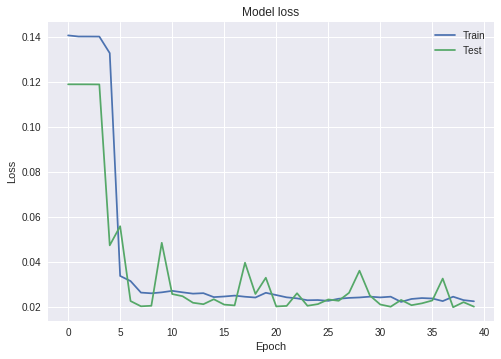

In [29]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## Conclusion

The model passed proof of concept phase, it does learn and gives OK prediction, more data will lead to even more accurate results.